In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.base import BaseReweight
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling
from pflow.optimal_transport.recentering import LearnBest, IncrementalLearning

In [2]:
import pykalman
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class LorenzSystem(object):
    def __init__(self, sigma, rho, beta, dt, eps=1e-3, initial_state=None, random_state=None):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.counter = 0
        self.eps = eps
        self.dt = dt
        if random_state is None:
            self.random_state = np.random.RandomState()
        elif isinstance(random_state, np.random.RandomState):
            self.random_state = random_state
        elif isinstance(random_state, int):
            self.random_state = np.random.RandomState(random_state)
        if initial_state is not None:
            assert len(initial_state) == 3
            self.state = initial_state
        else:
            self.state = self.random_state.uniform(-1, 1, 3)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        x, y, z = self.state
        if self.counter == 0:
            pass
        else:
            dx_dt = self.sigma * (y - x)
            dy_dt = x * (self.rho - z) - y
            dz_dt = x * y - self.beta * z
            x += dx_dt * self.dt
            y += dy_dt * self.dt
            z += dz_dt * self.dt
            self.state = x, y, z
        self.counter += 1
        x_ = x + self.eps * self.random_state.normal(0., 1.)        
        y_ = y + self.eps * self.random_state.normal(0., 1.)
        z_ = z + self.eps * self.random_state.normal(0., 1.)
        return x_, y_, z_


In [4]:
class BrownianProposalMethod(ProposalMethodBase):
    def __init__(self, transition, lower_triang_chol):
        self.transition = transition
        locs = torch.zeros(lower_triang_chol.shape[0], requires_grad=False)
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=lower_triang_chol)
        
    def apply(self, state, _observation):
        x = state.x
        sample = self._dist.rsample((x.shape[0],))
        x_proposed = ((state.x @ self.transition) + sample)
        return FilterState(x=x_proposed, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix, obs_cov_triang):
        locs = torch.zeros(obs_cov_triang.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, scale_tril=obs_cov_triang)
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        


In [5]:
_ = torch.random.manual_seed(0)

In [6]:
K = 10000
dt = 0.01
lorenzSystem = LorenzSystem(10., 28., 8/3, dt, eps=5., random_state=41)

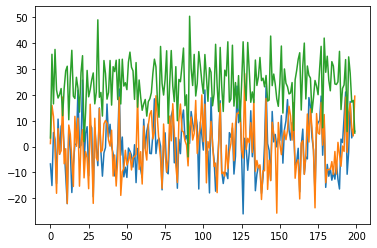

In [7]:
lorenz_observations = [next(lorenzSystem) for i in range(K)]
lorenz_observations = [obs for i, obs in enumerate(lorenz_observations) if not i % 50 ]
lorenz_observations = np.asanyarray(lorenz_observations).astype(np.float32)
plt.plot(lorenz_observations)

In [8]:
kf = pykalman.KalmanFilter(observation_covariance=np.eye(3), 
                           transition_covariance=np.eye(3), 
                            transition_matrices=np.eye(3), 
                            initial_state_mean=[0., 0., 0.])
kf.em(lorenz_observations, em_vars = ['observation_covariance', 'transition_covariance' ], n_iter=50)

In [9]:
def run_pf(transition_covariance_lower, observation_covariance_lower, observations, reweighting_method, n=100, seed=0, min_neff=0.5):
    states = []
    
    torch.random.manual_seed(seed)
    initial_dist = torch.distributions.MultivariateNormal(torch.tensor([0., 0., 0.]), scale_tril=torch.eye(3))
    initial_x = initial_dist.rsample((n,)).clone()
#     fig, axes = plt.subplots(K+1, sharex=True, sharey=False)
    initial_w = torch.full((n,), 1/n, requires_grad=True)
#     axes[0].hist(initial_x[:, 0].detach(), weights = initial_w.detach(), alpha = 0.3)

    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    transition_covariance_lower_torch = torch.tensor(transition_covariance_lower)
    transition_matrix = torch.eye(3)
    
    obs_triang = torch.tensor(observation_covariance_lower)
    obs_matrix = torch.eye(3, requires_grad=False)
    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    
    likelihood_method = LikelihoodMethod(obs_matrix, obs_triang)
    boot = BootstrapFilter(proposal_method=BrownianProposalMethod(transition_matrix, transition_covariance_lower_torch),
                           likelihood_method=likelihood_method, 
                           reweighting_method=reweighting_method,
                           min_neff=min_neff)
    n_obs = 0
    for val in observations:
        n_obs += 1
        obs = Observation(torch.tensor(val, requires_grad=False))
        
        state = boot.update(state, obs)
#         axes[n_obs].hist(state.x[:, 0].detach(), weights = state.w.detach(), alpha = 0.3, color = 'orange')
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik / n_obs, states, observations

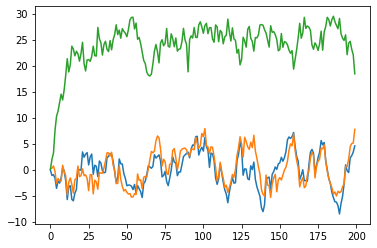

In [10]:
plt.plot(kf.filter(lorenz_observations)[0])

In [23]:
systematicResampling = SystematicResampling()
bestResampling = LearnBest(0.1, {'scaling': 0.33, 'reach': 5.}, {'lr': 1.}, n_steps=10, start_from_systematic=True, jitter=1e-2)
biasedResampling = Transport(epsilon=0.01, scaling=0.75, reach=5.)

transition_covariance_lower = np.linalg.cholesky(kf.transition_covariance).astype(np.float32)
observation_covariance_lower = np.linalg.cholesky(kf.observation_covariance).astype(np.float32)

res_systematic = run_pf(transition_covariance_lower, observation_covariance_lower, lorenz_observations, systematicResampling, n=500, min_neff=0.25)
print('done')
res_best = run_pf(transition_covariance_lower, observation_covariance_lower, lorenz_observations, bestResampling, n=500, min_neff=0.25)
print('done')
res_biased = run_pf(transition_covariance_lower, observation_covariance_lower, lorenz_observations, biasedResampling, min_neff=0.25)
print('done')

done
done
done


In [24]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, np.sqrt(variance))

In [25]:
def plot_pf_component(pf_res, component, ax, label):
    pf_state, pf_weight = zip(*[(l.x.detach().cpu().numpy(),  l.w.detach().cpu().numpy()) for l in pf_res[1]])
    pf_weight = np.stack(pf_weight, axis=0)
    pf_state = np.stack(pf_state, axis=0)

    pf_mean, pf_std = weighted_avg_and_std(pf_state[:, :, component].T,  pf_weight.T)
    ax.plot(linspace, pf_mean, label = label)
    ax.fill_between(linspace, 
                    pf_mean - 1 * pf_std,
                    pf_mean + 1 * pf_std, alpha = 0.3)
    return pf_mean, pf_std
    

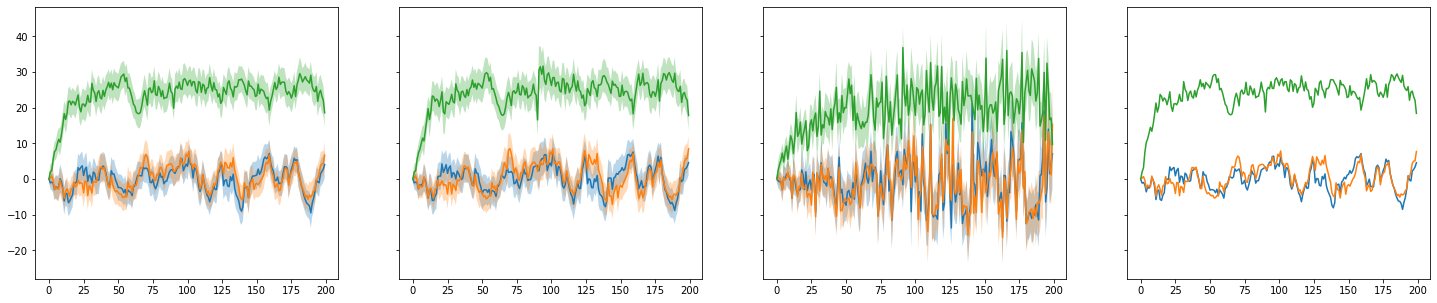

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5), sharex=True, sharey=True)
linspace = np.arange(0., len(lorenz_observations))

# axes[0, 0].plot(linspace, exact_filter[0][:, 0].squeeze(), label='KF')
# axes[0, 0].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')
# axes[0, 0].fill_between(linspace, 
#                         exact_filter[0][:, 0].squeeze() - 2*np.sqrt(exact_filter[1][:, 0, 0]),
#                         exact_filter[0][:, 0].squeeze() + 2*np.sqrt(exact_filter[1][:, 0, 0]), alpha = 0.3)

# axes[1, 0].plot(linspace, exact_filter[0][:, 1].squeeze(), label='KF')
# axes[1, 0].plot(linspace, np.cos(linspace), linestyle = '--')
# axes[1, 0].fill_between(linspace, 
#                         exact_filter[0][:, 1].squeeze() - 2*np.sqrt(exact_filter[1][:, 1, 1]),
#                         exact_filter[0][:, 1].squeeze() + 2*np.sqrt(exact_filter[1][:, 1, 1]), alpha = 0.3)

# sin
comp_0_sys_mean, comp_0_sys_std = plot_pf_component(res_systematic, 0, axes[0], 'systematic 0')
plot_pf_component(res_systematic, 1, axes[0], 'systematic 1')
plot_pf_component(res_systematic, 2, axes[0], 'systematic 2')
# axes[0].plot(linspace, lorenz_observations, linestyle = '--', label='Ground truth')

comp_0_best_mean, comp_0_best_std = plot_pf_component(res_best, 0, axes[1], 'best 0')
plot_pf_component(res_best, 1, axes[1], 'best 1')
plot_pf_component(res_best, 2, axes[1], 'best 2')

plot_pf_component(res_biased, 0, axes[2], 'biased 0')
plot_pf_component(res_biased, 1, axes[2], 'biased 1')
plot_pf_component(res_biased, 2, axes[2], 'biased 2')

axes[3].plot(linspace, kf.filter(lorenz_observations)[0])
# axes[1].plot(linspace, lorenz_observations, linestyle = '--', label='Ground truth')

# plot_pf_component(res_1_0, 0, axes[0, 2], 'particle filter, eps = 1')
# axes[0, 2].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# # plot_pf_component(res_learnt, 0, axes[0, 3], 'particle filter, learnt')
# # axes[0, 3].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_systematic, 0, axes[0, 3], 'particle filter, systematic')
# axes[0, 3].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# # plot_pf_component(res_no_resampling, 0, axes[0, 5], 'particle filter, no resampling')
# # axes[0, 5].plot(linspace, np.sin(linspace), linestyle = '--', label='Ground truth')

# # cos
# plot_pf_component(res_0_1, 1, axes[1, 1], 'particle filter, eps = 0.25')
# axes[1, 1].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_1_0, 1, axes[1, 2], '$OT_\epsilon$, eps = 1.0')
# axes[1, 2].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

# # plot_pf_component(res_learnt, 1, axes[1, 3], 'particle filter, learnt')
# # axes[1, 3].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

# plot_pf_component(res_systematic, 1, axes[1, 3], 'particle filter, systematic')
# axes[1, 3].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')

# # plot_pf_component(res_no_resampling, 1, axes[1, 5], 'particle filter, no resampling')
# # axes[1, 5].plot(linspace, np.cos(linspace), linestyle = '--', label='Ground truth')



# for ax in axes.flatten():
#     ax.legend(loc='upper right')

# axes[0, 0].set_title('sin(t)')
# _ = axes[1, 0].set_title('cos(t) - unobserved')

# fig.savefig('KF_OptimalTransportPF_comp.png')

In [27]:
print((comp_0_best_mean - lorenz_observations[:, 0]).std())
print((comp_0_sys_mean - lorenz_observations[:, 0]).std())


8.836812
9.082499


(array([ 5.,  5., 18., 24., 37., 45., 39., 15., 11.,  1.]),
 array([-25.846996  , -20.844624  , -15.842253  , -10.839881  ,
         -5.837509  ,  -0.83513737,   4.1672344 ,   9.169606  ,
         14.171978  ,  19.17435   ,  24.176722  ], dtype=float32),
 <a list of 10 Patch objects>)

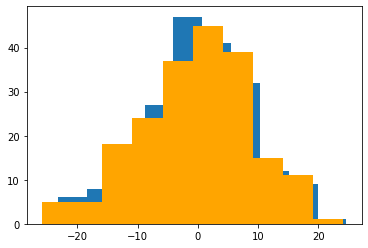

In [22]:
plt.hist(comp_0_best_mean - lorenz_observations[:, 0])
plt.hist(comp_0_sys_mean- lorenz_observations[:, 0], color = 'orange')

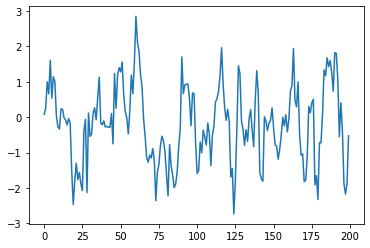

In [107]:
plt.plot(comp_0_sys_mean- kf.filter(lorenz_observations)[0][:, 0])

In [108]:
seeds = np.arange(0, 10).astype(int)
xs = np.linspace(0.5, 0.75, 10)
epsilons = [0.5, 0.75, 1.]

In [12]:
np.exp(5)

148.4131591025766

In [13]:
# gradient_list_ot = np.empty((len(epsilons), len(xs)))
# ll_list_ot = np.empty((len(epsilons), len(xs)))
# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     for j in tqdm.trange(len(xs)):
#         min_neff = xs[j]
#         test_res = run_pf(flat, log_sigma, dt_tensor, eps, n=100, scaling=0.95, min_neff=min_neff, seed=42, reach=1.)
#         ll = test_res[0]
#         grad = torch.autograd.grad(ll, log_sigma)[0].numpy().sum()
#         ll_list_ot[i, j] = ll
#         gradient_list_ot[i, j] = grad

In [14]:
# gradient_list_sys = np.empty((len(seeds), len(xs)))
# ll_list_sys = np.empty((len(seeds), len(xs)))
# for i in tqdm.trange(len(seeds)):
#     seed = seeds[i]
#     for j in range(len(xs)):
#         min_neff = xs[j]
#         test_res = run_pf(flat, log_sigma, dt_tensor, 0., n=100, min_neff=min_neff, seed=seed)
#         ll = test_res[0]
#         grad = torch.autograd.grad(ll, log_sigma)[0].numpy().sum()
#         ll_list_sys[i, j] = ll
#         gradient_list_sys[i, j] = grad

In [15]:
kf1 = pykalman.KalmanFilter(observation_covariance=[[0.5]], 
                            transition_covariance=[[0.05, 0.],
                                                       [0., 0.05]], 
                            transition_matrices=[[1., dt], 
                                                 [-dt, 1.]], 
                            initial_state_mean=[0., 1.])
kf2 = pykalman.KalmanFilter(observation_covariance=[[np.exp(math.log(0.5) + 2e-3)]], 
                                transition_covariance=[[0.05, 0.],
                                                       [0., 0.05]], 
                            transition_matrices=[[1., dt], 
                                                 [-dt, 1.]], 
                            initial_state_mean=[0., 1.])

In [16]:
exact_filter = kf1.filter(observations)

In [17]:
ll1 = -kf1.loglikelihood(observations) / K
ll2 = -kf2.loglikelihood(observations) / K
real_gradient = 1e3*(ll2-ll1)

In [18]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey='row')

# for ax in axes[-1, :].flatten():
#     ax.set_xlabel('minimum ESS (%)')
    
# axes[0, 0].set_ylabel('-loglikelihood')
# axes[0, 0].set_title(r'$OT_{\epsilon}$ resampling')
# axes[0, 1].set_title(r'Systematic resampling')
# axes[1, 0].set_ylabel(r'$-\nabla$ loglikelihood')
    
# for ax in axes[0, :].flatten():
#     ax.plot(xs, [ll1]*len(xs), linestyle='--', label = 'Theoretical log-likelihood', color='k')
    
# for ax in axes[1, :].flatten():
#     ax.plot(xs, [real_gradient]*len(xs), linestyle='--', label = 'Theoretical gradient', color='k')
    
# for eps, ll_ot in zip(epsilons, ll_list_ot):
#     axes[0, 0].plot(xs, ll_ot, label=f'EPS: {eps}')

# axes[0, 1].plot(xs, ll_list_sys.mean(axis=0), label='systematic resampling')
# axes[0, 1].fill_between(xs, 
#                         ll_list_sys.mean(axis=0) - 2 * ll_list_sys.std(axis=0),
#                         ll_list_sys.mean(axis=0) + 2 * ll_list_sys.std(axis=0), alpha = 0.3)
    
# for eps, grad_ot in zip(epsilons, gradient_list_ot):
#     axes[1, 0].plot(xs, grad_ot, label=f'EPS: {eps}')

# axes[1, 1].plot(xs, gradient_list_sys.mean(axis=0), label='systematic resampling')
# axes[1, 1].fill_between(xs, 
#                         gradient_list_sys.mean(axis=0) - 2 * gradient_list_sys.std(axis=0),
#                         gradient_list_sys.mean(axis=0) + 2 * gradient_list_sys.std(axis=0), alpha = 0.3)
# axes[1, 0].legend()

# fig.savefig('loglik_gradient.png')

In [22]:
linspace = np.linspace(0.25, 0.75, 400)

In [23]:
results_for_smoothness_ot_dict = {}
results_for_smoothness_ot_grad_dict = {}
for eps in [0.5, 0.75, 1.]:
    results_for_smoothness_ot_dict[eps] = []
    results_for_smoothness_ot_grad_dict[eps] = []
    for val in tqdm.tqdm(linspace):
        log_sigma_val = torch.tensor(math.log(val)/2, requires_grad=True)
#         with torch.autograd.detect_anomaly():
        temp_res = run_pf(flat, log_sigma_val, dt_tensor, eps, n=100, scaling=0.9, min_neff=0.5, reach=5.)
        results_for_smoothness_ot_grad_dict[eps].append(torch.autograd.grad(temp_res[0], log_sigma_val)[0].detach().cpu().numpy())
        results_for_smoothness_ot_dict[eps].append(temp_res[0].detach().cpu().numpy())
    


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:45<00:00,  2.58it/s]


In [25]:
results_for_smoothness_systematic_dict = {}
results_for_smoothness_systematic_grad_dict = {}
for n in [100]:
    results_for_smoothness_systematic_dict[n] = []
    results_for_smoothness_systematic_grad_dict[n] = []
    for val in tqdm.tqdm(linspace):
        log_sigma_val = torch.tensor(math.log(val)/2, requires_grad=True)
        temp_res = run_pf(flat, log_sigma_val, dt_tensor, 0., n=n)
        results_for_smoothness_systematic_grad_dict[n].append(torch.autograd.grad(temp_res[0], log_sigma_val)[0].detach().cpu().numpy())
        results_for_smoothness_systematic_dict[n].append(temp_res[0].detach().cpu().numpy())


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:02<00:00,  5.89it/s]


In [26]:
# results_for_learnt_ot_dict = {}
# eps = 0.1
# adam_kwargs = {'lr': 0.5}
# methods = {#'incremental': IncrementalLearning(eps, {'scaling': 0.5}, adam_kwargs, 4, 5),
#            'one-shot': LearnBest(eps, {'scaling': 0.75}, adam_kwargs, 10)}
# for name, method in methods.items():
#     results_for_learnt_ot_dict[name] = [~]
#     for val in tqdm.tqdm(linspace):
#         log_sigma_tensor = torch.tensor(val, requires_grad=False)
#         temp_res = run_pf(flat, log_sigma_tensor, dt_tensor, eps, n=250, reweighting_method=method)
#         results_for_learnt_ot_dict[name].append(temp_res[0].detach().cpu().numpy())


In [27]:
results_for_kalman = []
grads_for_kalman = []
for val in tqdm.tqdm(linspace):
    kf = pykalman.KalmanFilter(observation_covariance=[[val]], 
                               transition_covariance=[[0.05, 0.],
                                                       [0., 0.05]], 
                                transition_matrices=[[1., dt], 
                                                     [-dt, 1.]], 
                                observation_matrices=np.array([[1., 0.]]), 
                                initial_state_mean=np.array([0., 1.]), 
                                initial_state_covariance=np.eye(2))
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[math.exp(math.log(val)+2e-4)]], 
                                   transition_covariance=[[0.05, 0.],
                                                           [0., 0.05]], 
                                    transition_matrices=[[1., dt], 
                                                         [-dt, 1.]], 
                                    observation_matrices=np.array([[1., 0.]]), 
                                    initial_state_mean=np.array([0., 1.]), 
                                    initial_state_covariance=np.eye(2))
    ll = -kf.loglikelihood(observations)/K
    ll_eps = -kf_eps.loglikelihood(observations)/K
    results_for_kalman.append(ll)
    grads_for_kalman.append(1e4*(ll_eps-ll))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:09<00:00,  6.03it/s]


In [28]:
def plot_gradient(linspace, values, gradients, k, ax, line):
    x = np.take(linspace, k)
    y = np.take(values, k)
    v = np.take(gradients, k)
    u = [1]*len(k)
    ax.quiver(x, y, u, v, scale=20, zorder=3, color=l.get_color(),
          width=0.007, headwidth=3., headlength=4.)

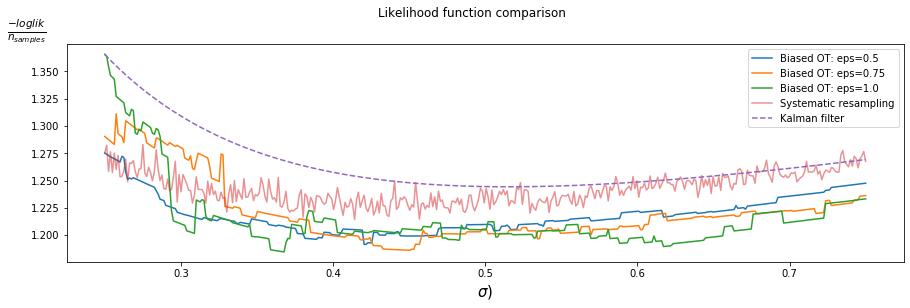

In [37]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4), sharey=False, sharex=False)
fig.suptitle('Likelihood function comparison', y = 1.01)

for eps, lst in results_for_smoothness_ot_dict.items():
    ax.plot(linspace, lst, label=f'Biased OT: eps={eps}')
ax.plot(linspace, results_for_smoothness_systematic_dict[100], label=f'Systematic resampling', alpha=0.5)
ax.plot(linspace, results_for_kalman, label = 'Kalman filter', linestyle = '--')

# zoom = slice(0, 250)
# grads_locs =  [25, 100, 175]
# for eps, lst in results_for_smoothness_ot_dict.items():
#     l, = axes[1].plot(linspace[zoom], lst[zoom], label=f'Biased OT: eps={eps}')
#     plot_gradient(linspace, lst, results_for_smoothness_ot_grad_dict[eps], grads_locs, axes[1], l)

# l, = axes[1].plot(linspace[zoom], results_for_smoothness_systematic_dict[100][zoom], label=f'Systematic resampling', alpha=0.5)
# plot_gradient(linspace, results_for_smoothness_systematic_dict[100], results_for_smoothness_systematic_grad_dict[100], grads_locs, axes[1], l)

# axes[1].plot(linspace[zoom], results_for_kalman[zoom], label = 'Kalman filter', linestyle = '--')

# for ax in axes.flatten():
ax.set_ylabel('$\\frac{-loglik}{n_{samples}}$', rotation=0, y=1, fontsize=15)
ax.set_xlabel('$\sigma)$', rotation=0, y=1, fontsize=15)
    
ax.legend()
    
fig.savefig('likelihood.png')

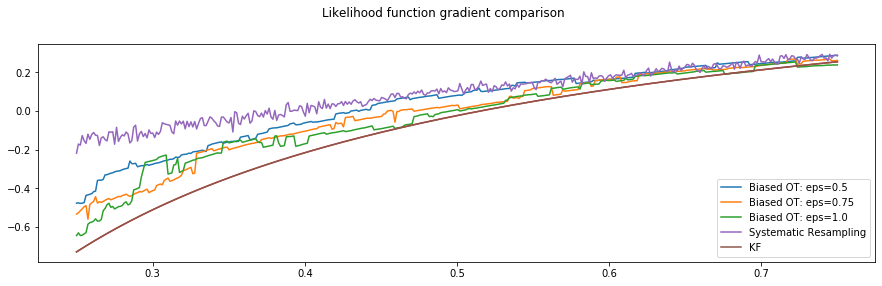

In [32]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Likelihood function gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    ax.plot(linspace, np.stack(grads), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.stack(grads_for_kalman))

ax.plot(linspace, np.stack(results_for_smoothness_systematic_grad_dict[100]), label='Systematic Resampling')
ax.plot(linspace, np.stack(grads_for_kalman), label='KF')

ax.legend()
fig.savefig('likelihoodGradient.png')

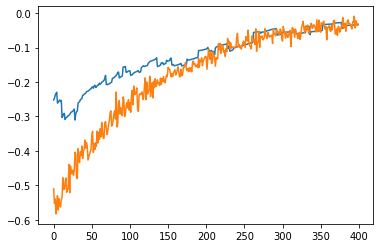

In [38]:
plt.plot(np.stack(grads_for_kalman) - np.stack(results_for_smoothness_ot_grad_dict[0.5]))
plt.plot(np.stack(grads_for_kalman) - np.stack(results_for_smoothness_systematic_grad_dict[100]))